# Deep Learning (TensorFlow, Keras) with ResNet50: Image Multi-class Classifier (Part 1)
In this project, a model is trained to perform multi-class classification for apple, banana and orange pictures. The pretrained model ResNet50 is used. This document is the first part of the whole training process.

The dataset can be found in (805 MB):

https://www.kaggle.com/datasets/shivamardeshna/fruits-dataset

## Iteration 1: Model creation and training (learning_rate=1e-4) without data augmentation and no fine-tuning yet

In [23]:
# (height, width, channels)
input_shape = (224, 224, 3)
batch_size = 12
learning_rate = 1e-4
neurons = 128
path_dataset = '../fruits_dataset'
folder_apple = 'apple'
folder_banana = 'banana'
folder_orange = 'orange'
folder_models = '../models'

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [25]:
# Find how many apple, banana, and orange images exist
apple_imgs = os.listdir(os.path.join(path_dataset,folder_apple))
banana_imgs = os.listdir(os.path.join(path_dataset,folder_banana))
orange_imgs = os.listdir(os.path.join(path_dataset,folder_orange))
print(f'Apple images found: {len(apple_imgs)}')
print(f'Banana images found: {len(banana_imgs)}')
print(f'Orange images found: {len(orange_imgs)}')

Apple images found: 866
Banana images found: 777
Orange images found: 943


Classes are balanced.

### No Data augmentation

In [26]:
def load_data(path, input_shape=input_shape, batch_size=batch_size, seed=123, validation_split=0.2):
    """Function to create 2 ImageDataGenerators to split dataset into train and validation datasets.
    Data augmentation is not implemented for the validation dataset."""
    height, width = input_shape[:2]
    datagen = ImageDataGenerator(rescale=1.0/255, zoom_range=0,
        horizontal_flip=True, vertical_flip=False,
        height_shift_range=0, width_shift_range=0,
        brightness_range=(0.99, 1.0), rotation_range=0,
        validation_split=validation_split
    )
    train_data = datagen.flow_from_directory(path,
        target_size=(height, width), batch_size=batch_size,
        class_mode='sparse', subset='training', seed=seed
    )
    val_datagen = ImageDataGenerator(rescale=1.0/255,
        validation_split=validation_split
    )
    val_data = val_datagen.flow_from_directory(path,
        target_size=(height, width), batch_size=batch_size,
        class_mode='sparse', subset='validation', seed=seed
    )
    return train_data, val_data

# Split training and validation datasets
train, val = load_data(path_dataset)

print(f"Classes found: {train.class_indices}")
print(f"Training images: {train.samples}")
print(f"Validation images: {val.samples}")

Found 2070 images belonging to 3 classes.
Found 516 images belonging to 3 classes.
Classes found: {'apple': 0, 'banana': 1, 'orange': 2}
Training images: 2070
Validation images: 516


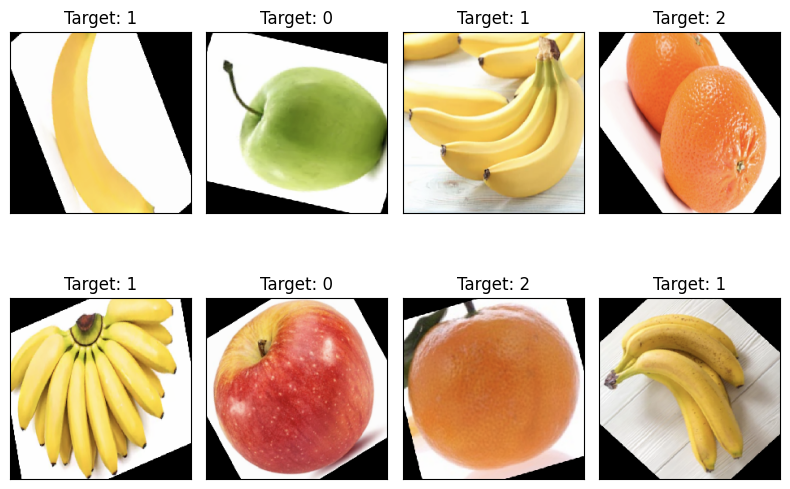

(12, 224, 224, 3)


In [27]:
# Obtain images and target
images, labels = next(train)

# Show 8 training images (batch_size=8)
figure, axes = plt.subplots(nrows=2,ncols=4, figsize=(8, 6))
for item in zip(axes.ravel(), images, labels):
    axes, image, target = item
    axes.imshow(image)
    axes.set_title(f'Target: {target:0.0f}')
    axes.set_xticks([])
    axes.set_yticks([])
plt.tight_layout()
plt.show()

# Image dimensions
print(images.shape)

### Model training

In [28]:
def create_resnet_model(input_shape=input_shape, neurons=neurons,
                        learning_rate=learning_rate):
    """Function to create the model using the pretrained model
    'ResNet50' and adding some final layers. The backbone is 'ResNet50',
    but it is freezed (not trained) in this iteration."""
    
    backbone = ResNet50(weights='imagenet', input_shape=input_shape,
                        include_top=False)

    # Freeze ResNet50 without the top
    backbone.trainable = False
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(neurons, activation='relu'))
    model.add(Dense(3, activation='softmax'))           # 3 classes
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def train_model(model, train_data, val_data, epochs, version_model):
    """Function to train the model and save the best one
    according to the validation accuracy."""
    file_name = os.path.join(folder_models,f'sparse_model_v{version_model}.h5')
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=0),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=0),
        ModelCheckpoint(file_name, monitor='val_accuracy', save_best_only=True, verbose=1)
    ]

    history = model.fit(train_data, validation_data=val_data,
              epochs=epochs, callbacks=callbacks, verbose=2)

    return model, history

In [29]:
epochs = 25
version_model = 1
print(f"Parameters: batch_size = {batch_size}, learning_rate = {learning_rate}, neurons = {neurons}, epochs = {epochs}")

Parameters: batch_size = 12, learning_rate = 0.0001, neurons = 128, epochs = 25


In [30]:
# Create and train the model v1
model = create_resnet_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
 dense_3 (Dense)             (None, 3)                 387       
                                                                 
Total params: 23850371 (90.98 MB)
Trainable params: 262659 (1.00 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [31]:
print(f"TensorFlow Version: {tf.__version__}")

# Ensure GPU is available
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0],True)
    print("GPU is available and memory growth is enabled.")
else:
    print("GPU not available, training will be on CPU.")

TensorFlow Version: 2.13.1
GPU not available, training will be on CPU.


In [32]:
# Train the model
model, history_stage1 = train_model(model, train, val, epochs=epochs, version_model=version_model)

Epoch 1/25

Epoch 1: val_accuracy improved from -inf to 0.36822, saving model to ../models/sparse_model_v1.h5


/home/ant/TensorFlow-Keras-Multi-class-Classifier/env/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


173/173 - 228s - loss: 1.0843 - accuracy: 0.3961 - val_loss: 1.0792 - val_accuracy: 0.3682 - lr: 1.0000e-04 - 228s/epoch - 1s/step
Epoch 2/25

Epoch 2: val_accuracy improved from 0.36822 to 0.38760, saving model to ../models/sparse_model_v1.h5
173/173 - 239s - loss: 1.0176 - accuracy: 0.4826 - val_loss: 1.0606 - val_accuracy: 0.3876 - lr: 1.0000e-04 - 239s/epoch - 1s/step
Epoch 3/25

Epoch 3: val_accuracy improved from 0.38760 to 0.38953, saving model to ../models/sparse_model_v1.h5
173/173 - 172s - loss: 0.9747 - accuracy: 0.5411 - val_loss: 1.0566 - val_accuracy: 0.3895 - lr: 1.0000e-04 - 172s/epoch - 995ms/step
Epoch 4/25

Epoch 4: val_accuracy improved from 0.38953 to 0.39922, saving model to ../models/sparse_model_v1.h5
173/173 - 171s - loss: 0.9494 - accuracy: 0.5609 - val_loss: 1.0538 - val_accuracy: 0.3992 - lr: 1.0000e-04 - 171s/epoch - 991ms/step
Epoch 5/25

Epoch 5: val_accuracy improved from 0.39922 to 0.41667, saving model to ../models/sparse_model_v1.h5
173/173 - 175s - l

**Result 1:** val_accuracy=64.7%.

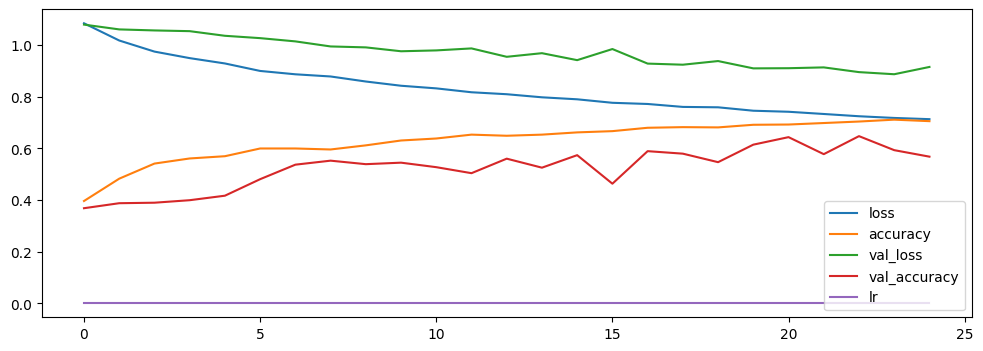

In [35]:
pd.DataFrame(history_stage1.history).plot(figsize=(12, 4))
plt.show()

In [34]:
# Save model
# model.save(os.path.join(folder_models,f'binary_model_v{version_model}.keras'))

In the next iteration, the model will be retrained, data augmentation and fine-tuning (last 10 layers) will be performed.